In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [46]:
cr_df_P0 = pd.read_csv("eval/results/correctness/P0/correctness_results_P0.csv")

cr_df_P1 = pd.read_csv("eval/results/correctness/P1/correctness_results_P1.csv")

cr_df_P2 = pd.read_csv("eval/results/correctness/P2/correctness_results_P2.csv")

cr_df_P3 = pd.read_csv("eval/results/correctness/P3/correctness_results_P3.csv")


In [47]:
def correctness_rates(df: pd.DataFrame) -> dict:
    """
    Returns failure rates (percentages) for:
    1) syntactic failures: syntactic_ok == 0 (out of all tests)
    2) execution failures: execution_ok == 0 (out of all tests)
    3) assertion failures among executed tests: execution_ok == 1 AND assertion_ok == 0
       (out of executed tests only)
    """
    total = len(df)
    if total == 0:
        raise ValueError("DataFrame is empty")

    syntactic_fail = (df["syntactic_ok"] == 0).sum()
    execution_fail = (df["execution_ok"] == 0).sum()

    # among executed tests, find assertions that did not pass
    executed = df[df["execution_ok"] == 1]
    executed_total = len(executed)
    assertion_fail_executed = (executed["assertion_ok"] == 0).sum() if executed_total > 0 else 0

    
    fully_correct = (
        (df["syntactic_ok"] == 1) &
        (df["execution_ok"] == 1) &
        (df["assertion_ok"] == 1)
    ).sum()
    

    return {
        "total_tests": total,
        "syntactic_fail_count": syntactic_fail,
        "syntactic_fail_pct": 100 * syntactic_fail / total,

        "execution_fail_count": execution_fail,
        "execution_fail_pct": 100 * execution_fail / total,

        "executed_tests": executed_total,
        "assertion_fail_executed_count": assertion_fail_executed,
        "assertion_fail_executed_pct": (100 * assertion_fail_executed / executed_total) if executed_total > 0 else 0.0,

        "fully_correct_count": fully_correct,
        "fully_correct_pct": 100 * fully_correct / total,
    }


In [48]:
#Make a table summary of correctness percentages and test counts

correctness_results = []

for strategy, df in [("P0", cr_df_P0), ("P1", cr_df_P1), ("P2", cr_df_P2), ("P3", cr_df_P3)]:
    r = correctness_rates(df)
    r["strategy"] = strategy
    correctness_results.append(r)

correctness_summary = pd.DataFrame(correctness_results)

# keep it readable
display_cols = [
    "strategy",
    "total_tests",
    "syntactic_fail_count", "syntactic_fail_pct",
    "execution_fail_count", "execution_fail_pct",
    "executed_tests",
    "assertion_fail_executed_count", "assertion_fail_executed_pct",
    "fully_correct_count", "fully_correct_pct",
]

correctness_summary = correctness_summary[display_cols].copy()
correctness_summary[["syntactic_fail_pct", "execution_fail_pct", "assertion_fail_executed_pct", "fully_correct_pct"]] = \
    correctness_summary[["syntactic_fail_pct", "execution_fail_pct", "assertion_fail_executed_pct", "fully_correct_pct"]].round(2)

correctness_summary


,strategy,total_tests,syntactic_fail_count,syntactic_fail_pct,execution_fail_count,execution_fail_pct,executed_tests,assertion_fail_executed_count,assertion_fail_executed_pct,fully_correct_count,fully_correct_pct
0,P0,72,1,1.39,7,9.72,65,1,1.54,64,88.89
1,P1,60,0,0.00,5,8.33,55,3,5.45,52,86.67
2,P2,67,0,0.00,1,1.49,66,2,3.03,64,95.52
3,P3,64,0,0.00,2,3.12,62,7,11.29,55,85.94


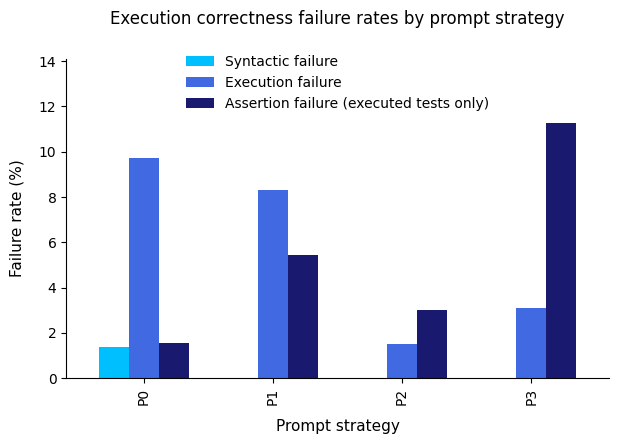

In [68]:
#Graph for correctness percentages

import matplotlib.pyplot as plt

plot_df = correctness_summary.set_index("strategy")[
    ["syntactic_fail_pct", "execution_fail_pct", "assertion_fail_executed_pct"]
]

colors = ['deepskyblue' , 'royalblue' , 'midnightblue']

fig, ax = plt.subplots(figsize=(7, 4.5))

plot_df.plot(
    kind="bar",
    ax=ax,
    color=colors,
    width=0.7
)

ax.set_ylabel("Failure rate (%)", fontsize=11, labelpad=10)
ax.set_xlabel("Prompt strategy", fontsize=11, labelpad=10)

ax.set_title(
    "Execution correctness failure rates by prompt strategy",
    pad=25  # push title upward
)

ax.set_ylim(0, plot_df.max().max() * 1.25)

ax.legend(
    [
        "Syntactic failure",
        "Execution failure",
        "Assertion failure (executed tests only)"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    frameon=False
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.subplots_adjust(top=0.82)

plt.show()

In [50]:
#Show which kind of execution errors did the LLM strrugle with the most (assertion errors not included)

def categorize_error(msg) -> str:
    # Handles NaN/None and non-strings safely
    msg = "" if pd.isna(msg) else str(msg)
    msg_l = msg.lower()

    if "valueerror" in msg_l:
        return "ValueError"
    if "attributeerror" in msg_l:
        return "AttributeError"
    if "typeerror" in msg_l:
        return "TypeError"
    if "assertionerror" in msg_l or "assert" in msg_l:
        return "AssertionFailure"

    return "Other"


error_summary = []

for strategy, df in [("P0", cr_df_P0), ("P1", cr_df_P1), ("P2", cr_df_P2), ("P3", cr_df_P3)]:
    exec_fail_df = df[(df["syntactic_ok"] == 1) & (df["execution_ok"] == 0)]

    categories = (
        exec_fail_df["error_message"]
        .fillna("")
        .apply(categorize_error)
    )

    counts = categories.value_counts()

    for cat, count in counts.items():
        error_summary.append({
            "strategy": strategy,
            "error_category": cat,
            "count": count
        })

error_summary_df = pd.DataFrame(error_summary)
error_summary_df


pivot = error_summary_df.pivot(
    index="error_category",
    columns="strategy",
    values="count"
).fillna(0)

pivot.astype(int)

#pivot.plot(kind="bar")

#plt.ylabel("Number of execution failures")
#plt.xlabel("Error category")
#plt.title("Execution error categories by prompt strategy")
#plt.xticks(rotation=0)
#plt.show()



strategy,P0,P1,P2,P3
error_category,,,,
AttributeError,2,1,0,1
Other,0,3,0,0
TypeError,1,1,1,1
ValueError,3,0,0,0
